In [1]:
import numpy as np
from qutip import destroy,liouvillian,steadystate,correlation_2op_1t,correlation_2op_2t,correlation_3op_1t,tensor, identity,spre,spost,expect, qeye,coherence_function_g2
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, LogNorm

In [2]:
def Liouv(γΣ, ΔΣ, ΩΣ):
    return np.array([
        [0, -1j*ΩΣ, 1j*ΩΣ, -γΣ],
        [-1j*ΩΣ, -1j*ΔΣ + γΣ/2, 0, 1j*ΩΣ],
        [1j*ΩΣ, 0, 1j*ΔΣ + γΣ/2, -1j*ΩΣ],
        [0, 1j*ΩΣ, -1j*ΩΣ, γΣ]
    ])

def Omega_side(γΣ, ΔΣ, ΩΣ):
    eigenvalues = np.linalg.eigvals(Liouv(γΣ, ΔΣ, ΩΣ))
    return np.imag(eigenvalues)[0]

In [3]:
# create operators
N=2 #Detector max number
σ = tensor(identity(N),identity(N),destroy(2))
a = tensor(destroy(N),identity(N),identity(2))
b = tensor(identity(N),destroy(N), identity(2))

The Hamiltonian and master equation of Elena's sensor method are given by, 
$$H_{σ}=\Delta_{\sigma}\sigma^\dagger\sigma+\Omega_\sigma(\sigma^\dagger+\sigma)\\
H_{s}=\Delta_a a^\dagger a +\Delta_b b^\dagger b \\
H_{sσ}=\epsilon(a^\dagger \sigma +a \sigma^\dagger) + \epsilon(b^\dagger \sigma +b \sigma^\dagger)\\
\partial_t\rho = i[\rho,H_\sigma +H_d]+(\gamma_\sigma/2)\mathcal{L}_{\sigma}(\rho)+(\Gamma/2)\mathcal{L}_{a}(\rho)+(\Gamma/2)\mathcal{L}_{b}(\rho)
$$

# $S(\omega)$

In [ ]:
σ = destroy(2)
γσ = 1
Δσ = 5 * γσ
Ωσ = 0.5 * γσ 

In [ ]:
def MollowTripletMESolver(Δσ, γσ, Ωσ):
    H = Δσ * σ.dag() * σ + Ωσ * (σ.dag() + σ)
    c_ops = [np.sqrt(γσ) * σ]
    L0 = liouvillian(H, c_ops)
    L = L0
    ρss = steadystate(L)
    
    tlist = np.linspace(0, 1000, 1000)
    taulist = tlist
    G1σ = correlation_2op_2t(L, ρss, tlist, taulist, [], σ.dag(), σ)
    
    G1σ_tau = abs(np.trapz(G1σ.transpose(), tlist))
    
    frequencies = np.fft.fftfreq(len(G1σ_tau), d=(tlist[1] - tlist[0]))
    spectrum = np.fft.fft(G1σ_tau)
    frequencies = np.fft.fftshift(frequencies)
    spectrum = np.real(np.fft.fftshift(spectrum))
    
    return frequencies, spectrum

In [ ]:
frequencies, spectrum = MollowTripletMESolver(Δσ, γσ, Ωσ)

In [ ]:
plt.plot(frequencies, spectrum)
plt.xlabel('Frequency')
plt.ylabel('Spectrum')
plt.yscale('log')
plt.title('Emission Spectrum')
plt.show()

# $g^{(2)}(\tilde{\omega}_a,\tilde{\omega}_b;\tau=0)$

In [4]:
def G2SS_Solver(Δσ,Δa,Δb,Ωσ,ε,γσ,Γ):
    H =  Δσ* σ.dag() * σ + + Ωσ * (σ.dag() + σ) + Δa * a.dag() * a + Δb * b.dag() * b + ε*(a.dag() * σ + a*σ.dag()) + ε*(b.dag() * σ + b*σ.dag())
    c_ops=[np.sqrt(γσ) * σ, np.sqrt(Γ) * a, np.sqrt(Γ) * b]
    L = liouvillian(H, c_ops)
    ρss = steadystate(L)
    #Cross correlation functions
    G2ab = np.real(correlation_3op_1t(H, ρss, [0], [], a.dag(), b.dag() * b , a))
    na = correlation_2op_1t(H, ρss, [0], [], a.dag(), a)
    nb = correlation_2op_1t(H, ρss, [0], [], b.dag(), b)
    g2ab=G2ab/(na *nb)
    return np.log10(np.real(g2ab[0]))

In [18]:
γσ = 1
Δσ = 0 * γσ
Ωσ = 5 * γσ 
Γ = 0.1 * γσ 
ε = 0.5*np.sqrt(Γ*γσ/2)
ΩRabi = Omega_side(γσ, Δσ, Ωσ)

In [19]:
Δa_values = ΩRabi *np.linspace(-2, 2, 151)
Δb_values = ΩRabi *np.linspace(-2, 2, 151)

g2ab_values = np.zeros((len(Δa_values), len(Δb_values)))

for i, Δa in enumerate(Δa_values):
    for j, Δb in enumerate(Δb_values):
        g2ab_values[i, j] = G2SS_Solver(Δσ, Δa, Δb, Ωσ, γσ, Γ, ε)

In [20]:
mn = g2ab_values.min()
Mx = g2ab_values.max()
mn

-0.3350645860733712

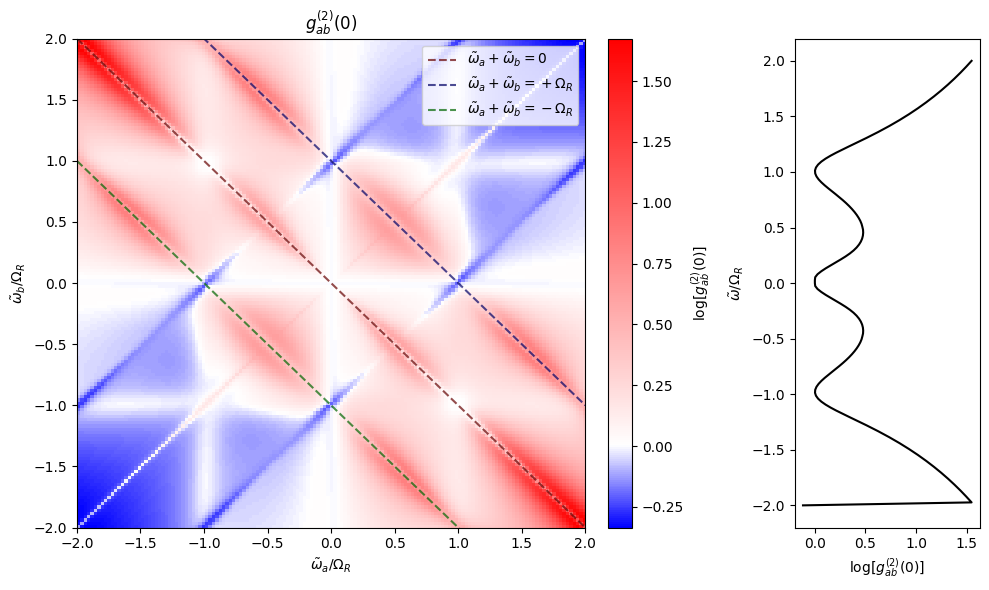

In [21]:
colors = [(0, "blue"), ((0 - mn) / (Mx - mn), "white"), (1, "red")]
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6), gridspec_kw={'width_ratios': [3, 1]})

im = ax1.imshow(g2ab_values, extent=[Δa_values.min()/ΩRabi, Δa_values.max()/ΩRabi, Δb_values.min()/ΩRabi, Δb_values.max()/ΩRabi],
                origin='lower', aspect='auto', cmap=cmap, vmin=mn, vmax=Mx)
ax1.plot(Δa_values / ΩRabi, -Δa_values / ΩRabi, linestyle='--', color=(102/255,0,0), alpha=0.7, label='$\\tilde{\\omega}_{a} + \\tilde{\\omega}_{b} = 0$')
ax1.plot(Δa_values / ΩRabi, (ΩRabi - Δa_values) / ΩRabi, linestyle='--', color=(0,0,102/255), alpha=0.7, label='$\\tilde{\\omega}_{a} + \\tilde{\\omega}_{b} = +\\Omega_{R}$')
ax1.plot(Δa_values / ΩRabi, (-ΩRabi - Δa_values) / ΩRabi, linestyle='--', color=(0,102/255,0), alpha=0.7, label='$\\tilde{\\omega}_{a} + \\tilde{\\omega}_{b} = -\\Omega_{R}$')
ax1.set_xlabel('$\\tilde{\\omega}_{a}/\\Omega_{R}$')
ax1.set_ylabel('$\\tilde{\\omega}_{b}/\\Omega_{R}$')
ax1.set_title('$g^{(2)}_{ab}(0)$')
ax1.set_xlim([-2, 2])
ax1.set_ylim([-2, 2])
ax1.legend()

cbar = fig.colorbar(im, ax=ax1, orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label('$\\log[g^{(2)}_{ab}(0)]$')

diagonal_values = np.array([g2ab_values[i, -i] for i in range(len(Δa_values))])
diagonal_freq = Δa_values / ΩRabi

ax2.plot(diagonal_values, diagonal_freq, color='black')
ax2.set_xlabel('$\\log[g^{(2)}_{ab}(0)]$')
ax2.set_ylabel('$\\tilde{\\omega}/\\Omega_{R}$')
#ax2.set_title('$\\tilde{\\omega}_{a} = \\tilde{\\omega}_{b}$')
#ax2.set_ylim([-2, 2])

plt.tight_layout()
plt.show()

In [ ]:
Δa_values = ΩRabi *np.linspace(-5, 5, 351)

g2ab_values_1cut = np.zeros((len(Δa_values)))

for i, Δa in enumerate(Δa_values):
    g2ab_values_1cut[i] = G2SS_Solver(Δσ, Δa, Δa, Ωσ, γσ, Γ, ε)

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(Δa_values/ΩRabi, (g2ab_values_1cut))
plt.xlabel('$\\omega_a / \\Omega_R$')
plt.ylabel('$\\log10\\left(g^{(2)}[0]\\right)$')
#plt.xlim(-0.1, 0.1)
plt.title('two time integrated second order correlation function')
plt.show()

# $g^{(2)}(\tilde{\omega}_a,\tilde{\omega}_b;\tau)$

In [ ]:
γσ=1 
Ωσ=1*γσ 
Γ=γσ 
Δσ=0 * Ωσ

ΩRabi=abs(Omega_side(γσ, Δσ, Ωσ))

In [ ]:
tau_list_pos = γσ * np.linspace(0, 20, 1000)  
tau_list_neg = γσ * np.linspace(-10, 0, 1000)  

In [ ]:
def G2τ_Solver(Δσ, Δa, Δb, Ωσ, γσ, Γdet, tau_list):
    H = Δσ * σ.dag() * σ + Δa * a.dag() * a + Δb * b.dag() * b + Ωσ * (σ.dag() + σ)
    c_ops = [np.sqrt(γσ) * σ, np.sqrt(Γdet) * a, np.sqrt(Γdet) * b]

    # Master equation superoperators
    L0 = liouvillian(H, c_ops)
    L1 = -np.sqrt(Γdet * γσ * 0.5) * (
        spre(a.dag() * σ)
        - spre(σ) * spost(a.dag())
        + spost(σ.dag() * a)
        - spre(a) * spost(σ.dag())
    ) - np.sqrt(Γdet * γσ * 0.5) * (
        spre(b.dag() * σ)
        - spre(σ) * spost(b.dag())
        + spost(σ.dag() * b)
        - spre(b) * spost(σ.dag())
    )
    L = L0 + L1    
    ρss = steadystate(L)

    # Cross correlation functions
    G2ab = np.real(correlation_3op_1t(L, ρss, tau_list, [], a.dag(), b.dag() * b, a))
    na = correlation_2op_1t(L, ρss, [0], [], a.dag(), a)
    nb = correlation_2op_1t(L, ρss, [0], [], b.dag(), b)    
    g2ab=G2ab / (na * nb)
    #g2a = coherence_function_g2(L, ρss, tau_list, c_ops, a, solver='me', args=None, options=None) 
    return np.real(g2ab)


In [ ]:
g2_values_pos = G2τ_Solver(Δσ, ΩRabi, -ΩRabi, Ωσ, γσ, Γ, tau_list_pos)
g2_values_neg = G2τ_Solver(Δσ, ΩRabi, -ΩRabi, Ωσ, γσ, Γ, tau_list_neg)


plt.figure(figsize=(8, 6))
plt.plot(tau_list_pos, g2_values_pos)
plt.xlabel('τ (time delay)')
plt.ylabel('$g^{(2)}_{ab}(τ)$')
plt.show()